# Multi-agent safe BO with time as a latent variable

Here, we go the classic SafeOpt route or even GP-UCB. It is mainly about testing the idea and seeing how the plots turn out. Whether we can map the problem to a time-series prediction problem. Let us start with 3 agents.
A1 is connected to A2. A2 is connected to A1 and A4. A4 is connected to A2. Acyclic graph.

In [1]:
import sys
import os
import torch

# Add the relative path to the system path
sys.path.append(os.path.abspath("./pacsbo"))
from pacsbo.pacsbo_main import compute_X_plot, ground_truth, initial_safe_samples
%matplotlib inline
import matplotlib.pyplot as plt

tensor(-0.3587)

# Random input into RKHS functions
We first want to check how an RKHS function behaves from the POV of one agent given that the rest is constant. We start with 2 agents and go up to 5. It does not matter which agent we take so one fixed agent per number of total agents rounds is fine. Maybe play with length scale a bit. Only then go into SafeOpt style where maybe some sort of pattern can be recognized.

## 2 agents

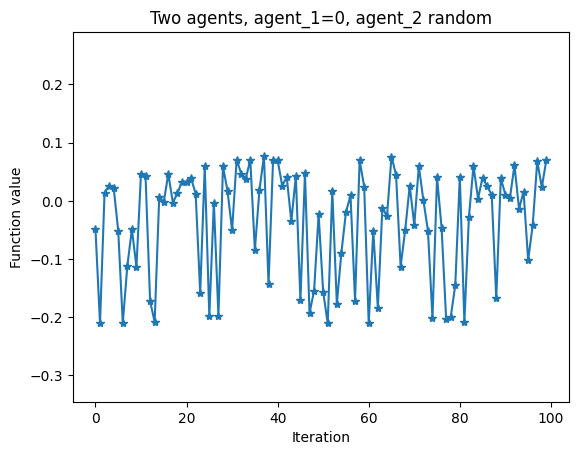

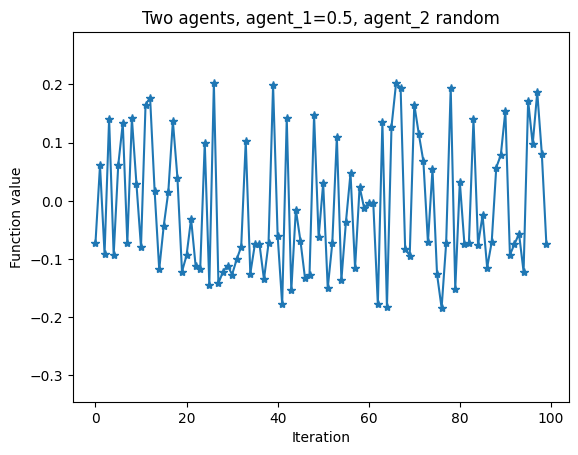

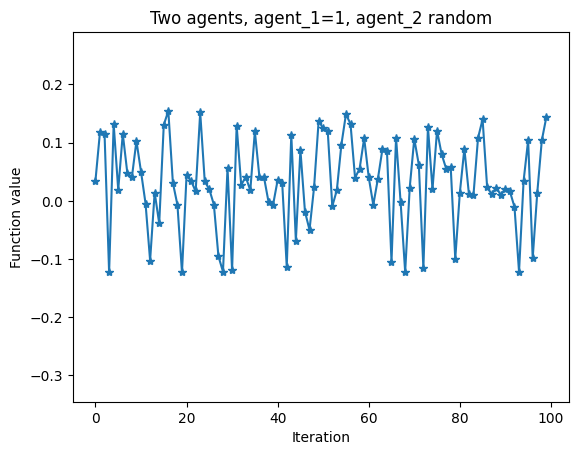

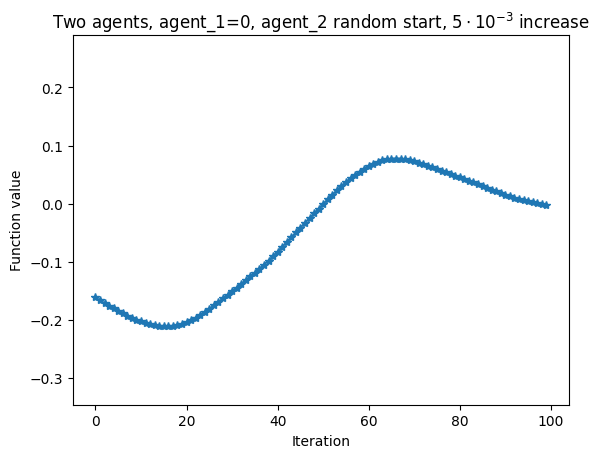

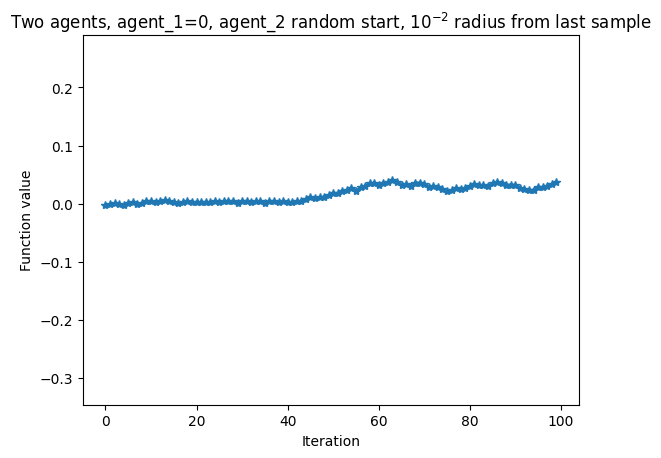

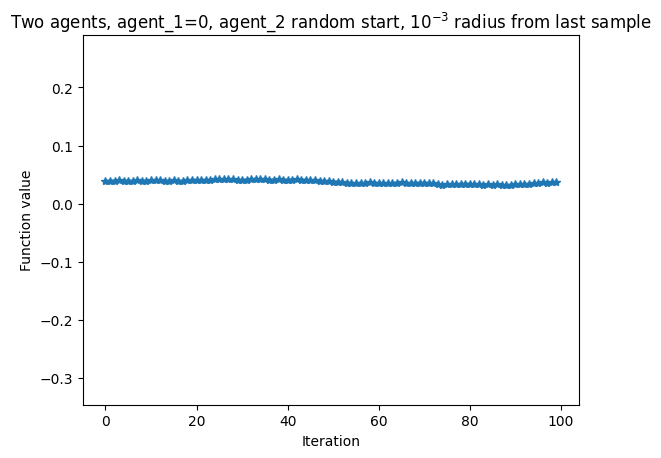

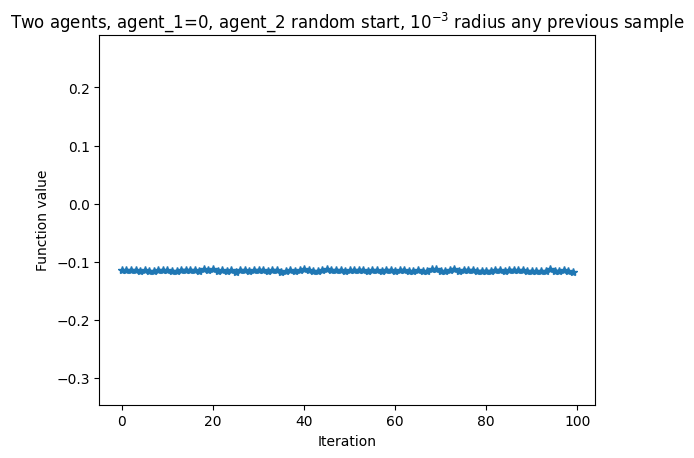

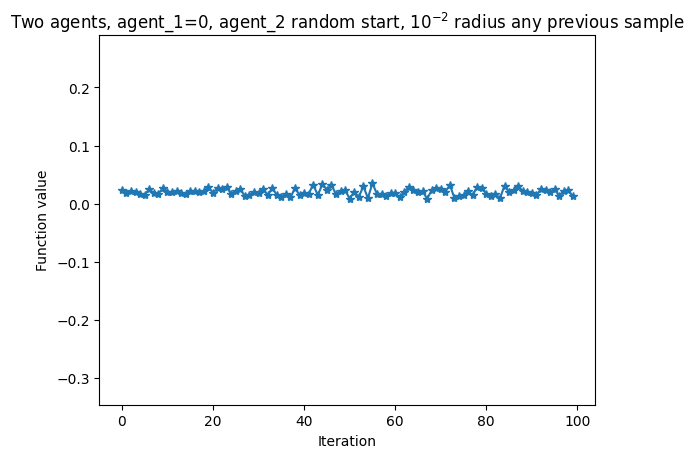

In [16]:
# Create function ground truth
# It is a 2D function for the 2 agents that we have
# Create function
lengthscale = 0.1
noise_std = 1e-2
RKHS_norm = 1
X_plot = compute_X_plot(n_dimensions=2, points_per_axis=1000)
gt = ground_truth(num_center_points=1000, X_plot=X_plot, RKHS_norm=RKHS_norm)  # cannot pickle this object

# a1=0
X2 = random_values = torch.rand(100)  # random 100 actions of the other agent
X = torch.stack((torch.zeros(100), X2), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, agent_2 random')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()

# a1=0.5
X2 = random_values = torch.rand(100)  # random 100 actions of the other agent
X = torch.stack((torch.ones(100)*0.5, X2), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0.5, agent_2 random')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()

# a1=1
X2 = random_values = torch.rand(100)  # random 100 actions of the other agent
X = torch.stack((torch.ones(100), X2), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=1, agent_2 random')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()



# Now random starting point but from there an incremental increase of 0.001
X2 = torch.linspace(torch.rand(1).item(), torch.rand(1).item() + 0.001 * 99, steps=100)
X = torch.stack((torch.zeros(100), X2), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, agent_2 random start, $10^{-3}$ increase')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()


# We can see that for random, we have no chance at all because it is just a noisy process. For sampling "closely" (last figure), the function is very smooth which is guaranteed by bounded RKHS norm.
# SafeOpt-style sampling will give us something in between.


# Now similar to last one. But just around a ball of radium 0.01 in which we can act randomly
# Radius is for the last point only 

X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

for i in range(1, 100):
    X2[i] = torch.clamp(X2[i - 1] + (torch.rand(1).item() - 0.5) * 0.02, 0, 1)
X = torch.stack((torch.zeros(100), X2), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, agent_2 random start, $10^{-2}$ radius from last sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()





# Now previous sample, radius 1e-3
X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001
for i in range(1, 100):
    X2[i] = torch.clamp(X2[i - 1] + (torch.rand(1).item() - 0.5) * 0.002, 0, 1)
X = torch.stack((torch.zeros(100), X2), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, agent_2 random start, $10^{-3}$ radius from last sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()




# Now any of the previous samples, radius 1e-3
X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001 from any previously sampled point
for i in range(1, 100):
    # Randomly select one of the previously sampled points
    previous_sample = X2[:i][torch.randint(0, i, (1,))]
    # Generate a new value within the radius of 0.001 from the selected sample
    new_value = previous_sample + (torch.rand(1) - 0.5) * 2e-3
    X2[i] = torch.clamp(new_value, 0.0, 1.0)

X = torch.stack((torch.zeros(100), X2), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, agent_2 random start, $10^{-3}$ radius any previous sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()



# Now any of the previous samples, radius 1e-2
X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001 from any previously sampled point
for i in range(1, 100):
    # Randomly select one of the previously sampled points
    previous_sample = X2[:i][torch.randint(0, i, (1,))]
    # Generate a new value within the radius of 0.001 from the selected sample
    new_value = previous_sample + (torch.rand(1) - 0.5) * 2e-2
    X2[i] = torch.clamp(new_value, 0.0, 1.0)

X = torch.stack((torch.zeros(100), X2), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, agent_2 random start, $10^{-2}$ radius any previous sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()




## 3 agents

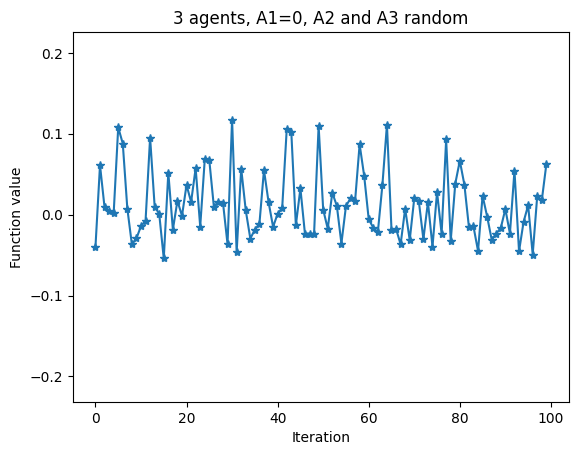

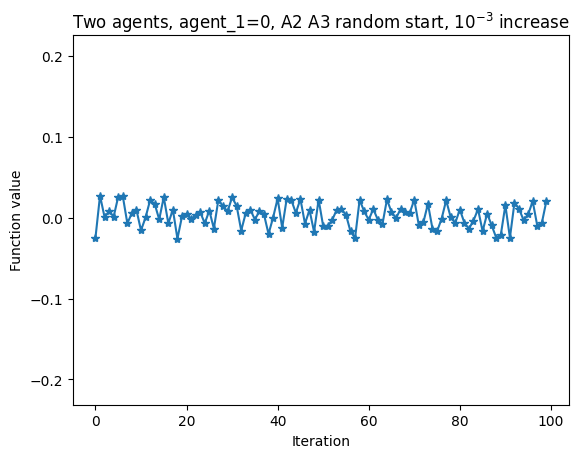

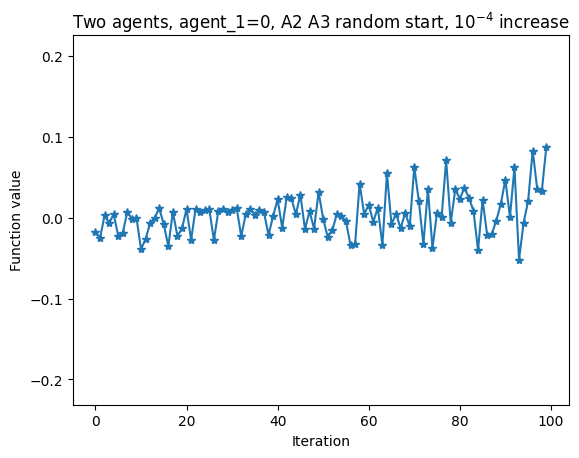

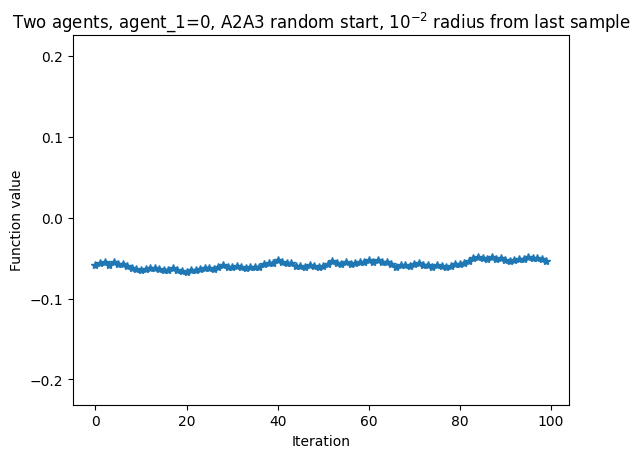

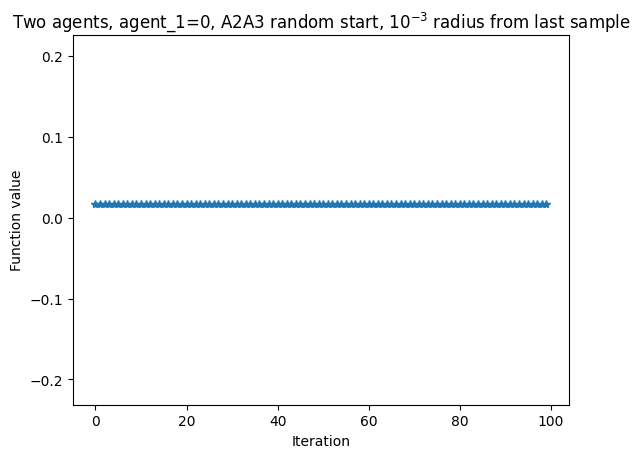

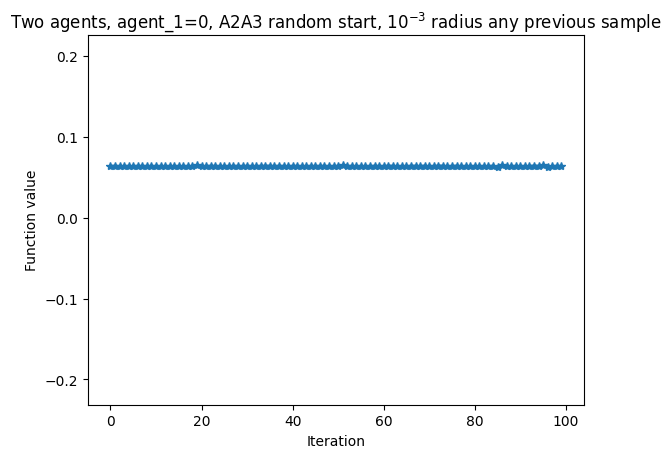

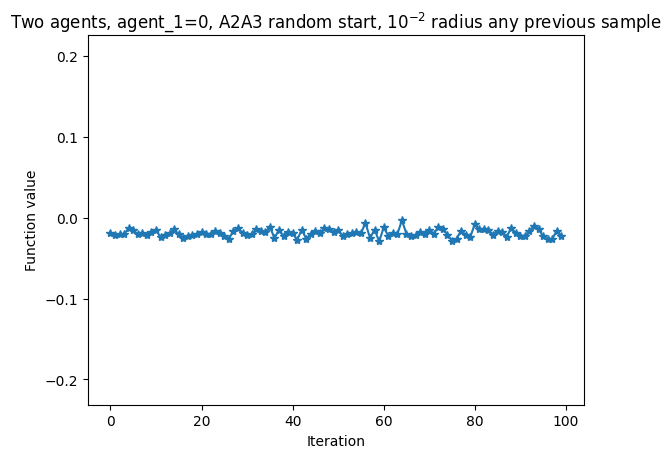

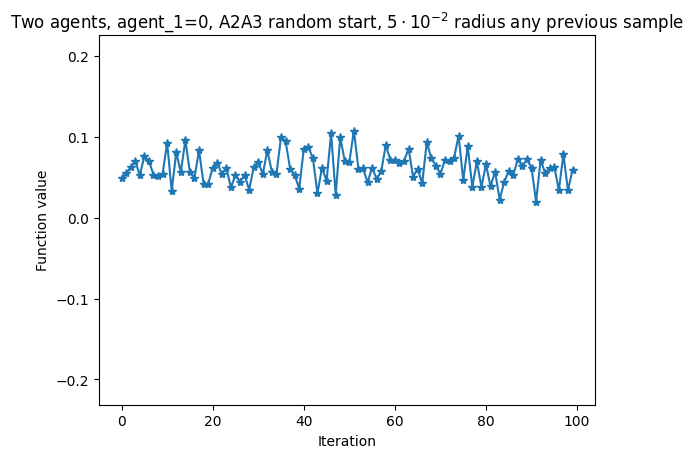

In [26]:
# Create function ground truth
# It is a 2D function for the 2 agents that we have
# Create function
lengthscale = 0.1
noise_std = 1e-2
RKHS_norm = 1
X_plot = compute_X_plot(n_dimensions=3, points_per_axis=100)  # not really that important
gt = ground_truth(num_center_points=1000, X_plot=X_plot, RKHS_norm=RKHS_norm)  # cannot pickle this object

# a1=0
X2 = random_values = torch.rand(100)  # random 100 actions of Agent 2
X3 = random_values = torch.rand(100)  # random 100 actions of Agent 3
X = torch.stack((torch.zeros(100), X2, X3), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('3 agents, A1=0, A2 and A3 random')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()


# Now random starting point but from there an incremental increase of 0.001
X2 = torch.linspace(torch.rand(1).item(), torch.rand(1).item() + 0.001 * 99, steps=100)
X2 = torch.linspace(torch.rand(1).item(), torch.rand(1).item() + 0.001 * 99, steps=100)
X = torch.stack((torch.zeros(100), X2, X3), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, A2 A3 random start, $10^{-3}$ increase')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()

# Now random starting point but from there an incremental increase of 0.0001
X2 = torch.linspace(torch.rand(1).item(), torch.rand(1).item() + 0.0001 * 99, steps=100)
X2 = torch.linspace(torch.rand(1).item(), torch.rand(1).item() + 0.0001 * 99, steps=100)
X = torch.stack((torch.zeros(100), X2, X3), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, A2 A3 random start, $10^{-4}$ increase')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()



# We can see that for random, we have no chance at all because it is just a noisy process. For sampling "closely" (last figure), the function is very smooth which is guaranteed by bounded RKHS norm.
# SafeOpt-style sampling will give us something in between.


# Now similar to last one. But just around a ball of radium 0.01 in which we can act randomly
# Radius is for the last point only 

X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

for i in range(1, 100):
    X2[i] = torch.clamp(X2[i - 1] + (torch.rand(1).item() - 0.5) * 0.02, 0, 1)

X3 = torch.zeros(100)
X3[0] = torch.rand(1)  # Start with a random value in [0, 1]

for i in range(1, 100):
    X3[i] = torch.clamp(X3[i - 1] + (torch.rand(1).item() - 0.5) * 0.02, 0, 1)

X = torch.stack((torch.zeros(100), X2, X3), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, A2A3 random start, $10^{-2}$ radius from last sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()





# Now previous sample, radius 1e-3
X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

for i in range(1, 100):
    X2[i] = torch.clamp(X2[i - 1] + (torch.rand(1).item() - 0.5) * 0.002, 0, 1)

X3 = torch.zeros(100)
X3[0] = torch.rand(1)  # Start with a random value in [0, 1]

for i in range(1, 100):
    X3[i] = torch.clamp(X3[i - 1] + (torch.rand(1).item() - 0.5) * 0.002, 0, 1)

X = torch.stack((torch.zeros(100), X2, X3), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, A2A3 random start, $10^{-3}$ radius from last sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()



# Now any of the previous samples, radius 1e-3
X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001 from any previously sampled point
for i in range(1, 100):
    # Randomly select one of the previously sampled points
    previous_sample = X2[:i][torch.randint(0, i, (1,))]
    # Generate a new value within the radius of 0.001 from the selected sample
    new_value = previous_sample + (torch.rand(1) - 0.5) * 2e-3
    X2[i] = torch.clamp(new_value, 0.0, 1.0)
X3 = torch.zeros(100)
X3[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001 from any previously sampled point
for i in range(1, 100):
    # Randomly select one of the previously sampled points
    previous_sample = X3[:i][torch.randint(0, i, (1,))]
    # Generate a new value within the radius of 0.001 from the selected sample
    new_value = previous_sample + (torch.rand(1) - 0.5) * 2e-3
    X3[i] = torch.clamp(new_value, 0.0, 1.0)
    


X = torch.stack((torch.zeros(100), X2, X3), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, A2A3 random start, $10^{-3}$ radius any previous sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()


# Now any of the previous samples, radius 1e-2
X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001 from any previously sampled point
for i in range(1, 100):
    # Randomly select one of the previously sampled points
    previous_sample = X2[:i][torch.randint(0, i, (1,))]
    # Generate a new value within the radius of 0.001 from the selected sample
    new_value = previous_sample + (torch.rand(1) - 0.5) * 2e-2
    X2[i] = torch.clamp(new_value, 0.0, 1.0)
X3 = torch.zeros(100)
X3[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001 from any previously sampled point
for i in range(1, 100):
    # Randomly select one of the previously sampled points
    previous_sample = X3[:i][torch.randint(0, i, (1,))]
    # Generate a new value within the radius of 0.001 from the selected sample
    new_value = previous_sample + (torch.rand(1) - 0.5) * 2e-2
    X3[i] = torch.clamp(new_value, 0.0, 1.0)
    


X = torch.stack((torch.zeros(100), X2, X3), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, A2A3 random start, $10^{-2}$ radius any previous sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()


# Now any of the previous samples, radius 5e-2
X2 = torch.zeros(100)
X2[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001 from any previously sampled point
for i in range(1, 100):
    # Randomly select one of the previously sampled points
    previous_sample = X2[:i][torch.randint(0, i, (1,))]
    # Generate a new value within the radius of 0.001 from the selected sample
    new_value = previous_sample + (torch.rand(1) - 0.5) * 1e-1
    X2[i] = torch.clamp(new_value, 0.0, 1.0)
X3 = torch.zeros(100)
X3[0] = torch.rand(1)  # Start with a random value in [0, 1]

# Radius is 0.001 from any previously sampled point
for i in range(1, 100):
    # Randomly select one of the previously sampled points
    previous_sample = X3[:i][torch.randint(0, i, (1,))]
    # Generate a new value within the radius of 0.001 from the selected sample
    new_value = previous_sample + (torch.rand(1) - 0.5) * 1e-1
    X3[i] = torch.clamp(new_value, 0.0, 1.0)
    


X = torch.stack((torch.zeros(100), X2, X3), dim=1)
function_values = torch.tensor(gt.f(X), dtype=torch.float32)
plt.figure()
plt.plot(range(len(function_values)), function_values, '-*')
plt.xlabel('Iteration')
plt.ylabel('Function value')
plt.title('Two agents, agent_1=0, A2A3 random start, $5\cdot 10^{-2}$ radius any previous sample')
plt.ylim([min(gt.fX), max(gt.fX)])
plt.show()





In [20]:
torch.rand(1).item()

0.4511294364929199

# 5 agents
Now we have 5 agents. For our localized SafeOpt implementations, more dimensions lead to smaller jumps ($\Delta_x$ parameter). 
This is not the case in the multi-agent setting. We can still have the normal jumps.

Try to understand the problem that occurs when increasing the number of agents. How is that problem connected? Very easy: This is a Eucledian distance problem. Lipschitz constant given. Eucledian distance grows with more dimensions and also more agents (equivalently in this case). However, with more dimensions in the single-agent case, we jump less (is this even true no I do not think so). 
In the multi-agent setting, we have same $\Delta x$ values but it just sums up to be more.
What can we do with this? Is there anything possible? There will definitely be a scenario where the number of agents is too large (let us say 100) where the distance vector norm is just too large. By construction of this idea.

# Now SafeOpt-style